we would like to predict penguin species from the numerical attributes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold


In [2]:
df = pd.read_csv(Path("data/penguins_size.csv"))
# Replace . that are in our data with NaN
df.replace('.', np.nan, inplace=True)

# Drop all rows that contain NaN as a value, since we don't want to use those in our calculations
df_clean = df.dropna()

X = df_clean.iloc[:,range(2, 6)].to_numpy()
y = df_clean.iloc[:,0].to_numpy()
N, M = X.shape

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

# Standardize the training and set set based on training set mean and std
mu = np.mean(X_train, axis=0)
sigma = np.std(X_train, axis=0)

X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

In [4]:
# Fit regularized logistic regression model to training data to predict
# the pengling species
lambda_interval = np.logspace(-8, 2, 50)
train_error_rate = np.zeros(len(lambda_interval))
test_error_rate = np.zeros(len(lambda_interval))
coefficient_norm = np.zeros(len(lambda_interval))

for k in range(0, len(lambda_interval)):
    mdl = LogisticRegression(penalty="l2", C=1 / lambda_interval[k])

    mdl.fit(X_train, y_train)

    y_train_est = mdl.predict(X_train).T
    y_test_est = mdl.predict(X_test).T

    train_error_rate[k] = np.sum(y_train_est != y_train) / len(y_train)
    test_error_rate[k] = np.sum(y_test_est != y_test) / len(y_test)

    w_est = mdl.coef_[0]
    coefficient_norm[k] = np.sqrt(np.sum(w_est**2))

min_error = np.min(test_error_rate)
opt_lambda_idx = np.argmin(test_error_rate)
opt_lambda = lambda_interval[opt_lambda_idx]

In [5]:
mdl.coef_

array([[-0.44778169,  0.23314563, -0.23269983, -0.1124431 ],
       [ 0.32462791,  0.15192486, -0.11089666, -0.2109714 ],
       [ 0.12315378, -0.38507049,  0.34359649,  0.3234145 ]])

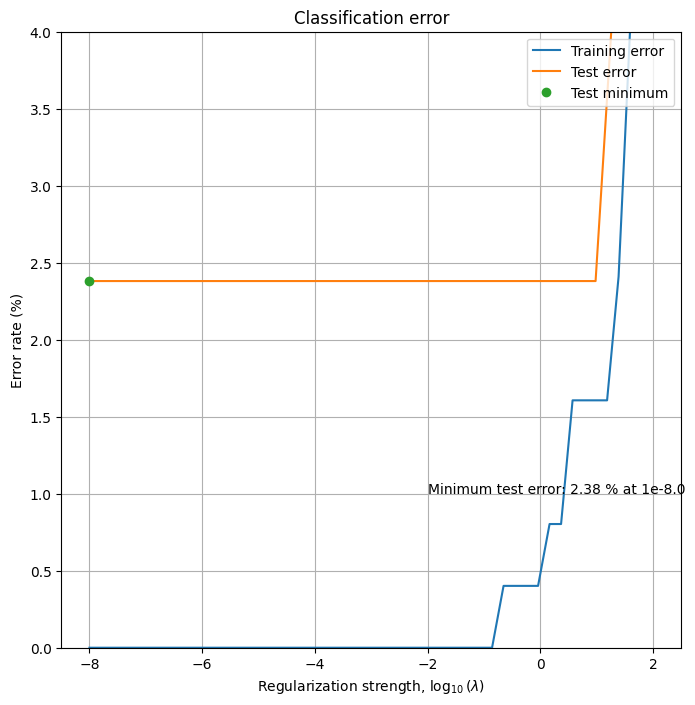

In [6]:
plt.figure(figsize=(8, 8))
plt.plot(np.log10(lambda_interval), train_error_rate*100)
plt.plot(np.log10(lambda_interval), test_error_rate*100)
plt.plot(np.log10(opt_lambda), min_error*100, 'o')
# plt.semilogx(lambda_interval, train_error_rate * 100)
# plt.semilogx(lambda_interval, test_error_rate * 100)
# plt.semilogx(opt_lambda, min_error * 100, "o")
plt.text(
    #1e-8,
    -2,
    1,
    "Minimum test error: "
    + str(np.round(min_error * 100, 2))
    + " % at 1e"
    + str(np.round(np.log10(opt_lambda), 2)),
)
plt.xlabel("Regularization strength, $\log_{10}(\lambda)$")
plt.ylabel("Error rate (%)")
plt.title("Classification error")
plt.legend(["Training error", "Test error", "Test minimum"], loc="upper right")
plt.ylim([0, 4])
plt.grid()
plt.show()


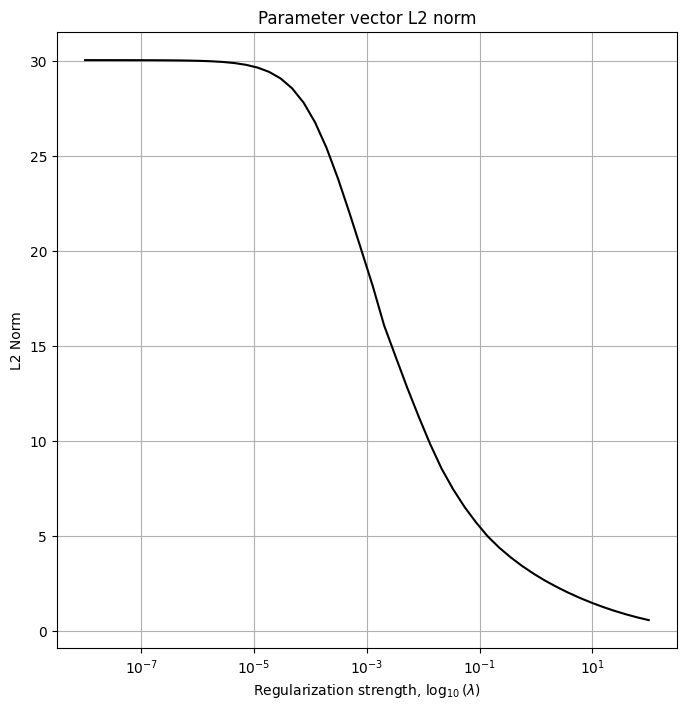

In [7]:
plt.figure(figsize=(8, 8))
plt.semilogx(lambda_interval, coefficient_norm, "k")
plt.ylabel("L2 Norm")
plt.xlabel("Regularization strength, $\log_{10}(\lambda)$")
plt.title("Parameter vector L2 norm")
plt.grid()
plt.show()

In [8]:
# baseline method: Adelie has 146, Gentee 119, Chinstrap 68

gentoo_count = (df_clean['species'] == 'Gentoo').sum()
adelie_count = (df_clean['species'] == 'Adelie').sum()
chinstrap_count = (df_clean['species'] == 'Chinstrap').sum()
total_penguins = gentoo_count + adelie_count + chinstrap_count

print("Number of Gentoo penguins:", gentoo_count)
print("Number of Adelie penguins:", adelie_count)
print("Number of Chinstrap penguins:", chinstrap_count)

print("Total penguins:",total_penguins)

# the error rate is the number of penguins that are not Adelie divided by the total number of penguins
# how often you are wrong if you always predict Adelie

baseline_error = (gentoo_count + chinstrap_count)/total_penguins
print("Baseline error:",baseline_error) 


Number of Gentoo penguins: 119
Number of Adelie penguins: 146
Number of Chinstrap penguins: 68
Total penguins: 333
Baseline error: 0.5615615615615616


In [9]:
X_train.shape

(249, 4)

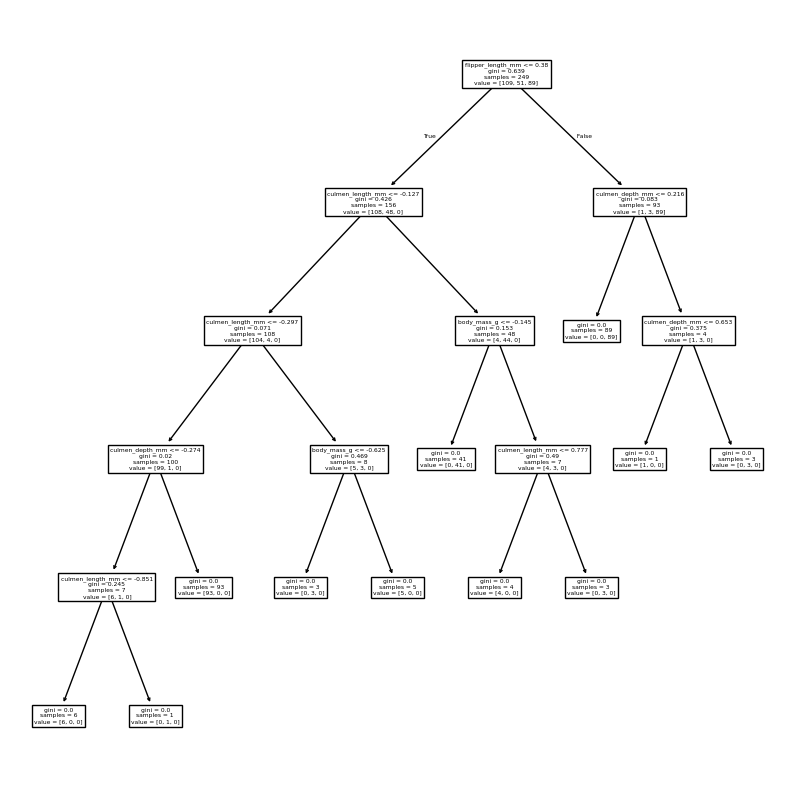

In [10]:
# try classification trees
from sklearn import tree
attributeNames = ['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g']

# Fit regression tree classifier, Gini split criterion, no pruning
criterion = "gini"
dtc = tree.DecisionTreeClassifier(criterion=criterion, min_samples_split=2)
dtc = dtc.fit(X_train, y_train)

# Visualize the graph (you can also inspect the generated image file in an external program)
# NOTE: depending on your setup you may need to decrease or increase the figsize and DPI setting
# to get a readable plot. Hint: Try to maximize the figure after it displays.

fig = plt.figure(figsize=(10, 10), dpi=100)
_ = tree.plot_tree(dtc, filled=False, feature_names=attributeNames)
plt.show()

In [11]:
from sklearn.metrics import accuracy_score

# Make predictions on the dataset
predictions = dtc.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)

# Calculate error rate
error_rate = 1 - accuracy

print(f"Error Rate: {error_rate}")


Error Rate: 0.0714285714285714


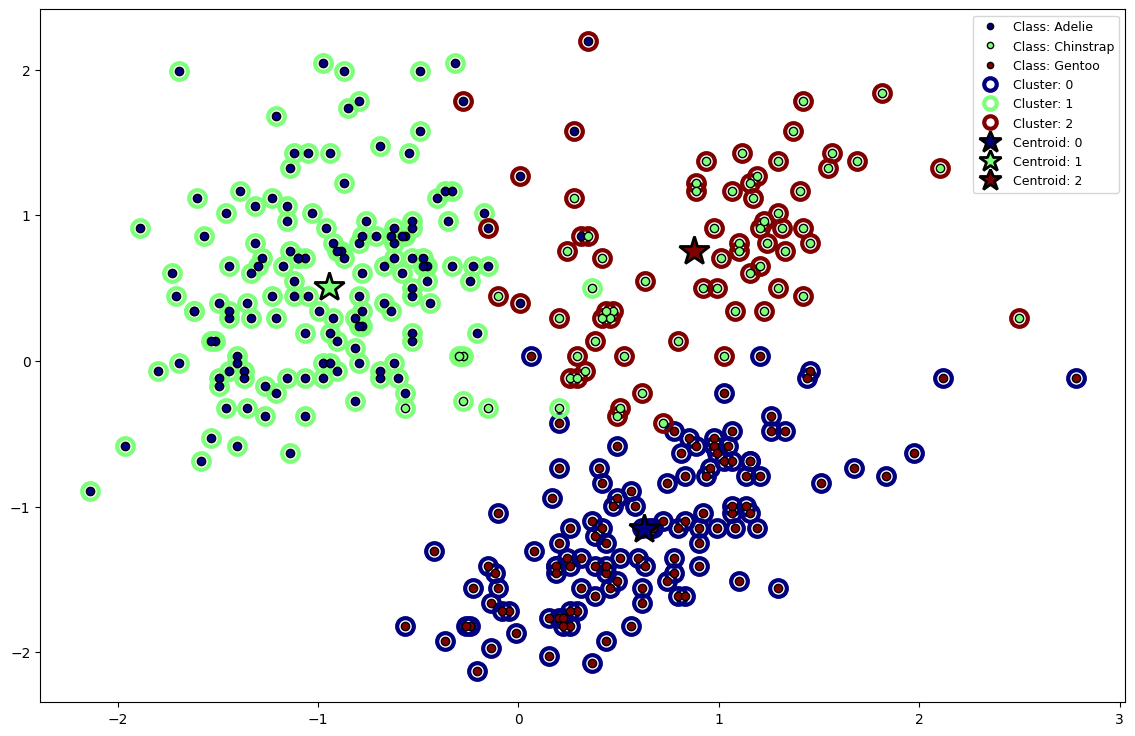

In [12]:
# try k-nearest neighbor
from matplotlib.pyplot import figure, show
from sklearn.cluster import k_means
from dtuimldmtools import clusterplot

# Number of clusters:
K = 3

# K-means clustering:
X_merged = np.concatenate([X_train,X_test])
y_merged = np.concatenate([y_train,y_test])
centroids, cls, inertia = k_means(X_merged, K)

# Plot results:
figure(figsize=(14, 9))
clusterplot(X_merged, cls, centroids, y_merged)
show()


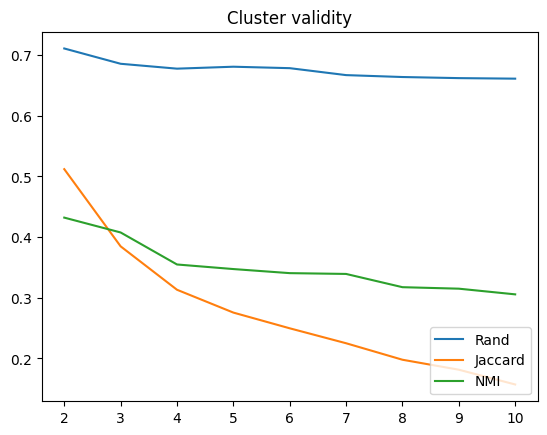

In [13]:
from matplotlib.pyplot import figure, legend, plot, show, title, ylim
from dtuimldmtools import clusterval

# Maximum number of clusters:
K = 10

# Allocate variables:
Rand = np.zeros((K-1,))
Jaccard = np.zeros((K-1,))
NMI = np.zeros((K-1,))

for k in range(K-1):
    # run K-means clustering:
    #cls = Pycluster.kcluster(X,k+1)[0]
    centroids, cls, inertia = k_means(X,k+2)
    # compute cluster validities:
    Rand[k], Jaccard[k], NMI[k] = clusterval(y,cls)    
        
# Plot results:

figure(1)
title('Cluster validity')
plot(np.arange(K-1)+2, Rand)
plot(np.arange(K-1)+2, Jaccard)
plot(np.arange(K-1)+2, NMI)
legend(['Rand', 'Jaccard', 'NMI'], loc=4)
show()

# A high cluster validity score indicates that the clustering model has formed groups that closely match 
# the true labels or the natural structure within the data

# While K-Means is an unsupervised clustering algorithm, KNN is a supervised classifier. 
# If you use K-Means to preprocess or create features for a KNN model, 
# having more clusters than species can serve as input features, 
# which may help improve KNN’s classification accuracy by capturing finer details within each class.

In [14]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
print(neigh.predict(X_test))
print(neigh.predict_proba(X_test))
print(neigh.score(X_test, y_test))

# seems to work well regardless of how many neighbors i use

['Adelie' 'Gentoo' 'Chinstrap' 'Chinstrap' 'Chinstrap' 'Adelie'
 'Chinstrap' 'Gentoo' 'Adelie' 'Gentoo' 'Gentoo' 'Adelie' 'Adelie'
 'Adelie' 'Gentoo' 'Gentoo' 'Chinstrap' 'Adelie' 'Gentoo' 'Gentoo'
 'Adelie' 'Gentoo' 'Adelie' 'Gentoo' 'Gentoo' 'Gentoo' 'Gentoo'
 'Chinstrap' 'Gentoo' 'Adelie' 'Adelie' 'Chinstrap' 'Adelie' 'Adelie'
 'Chinstrap' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Gentoo' 'Adelie'
 'Adelie' 'Chinstrap' 'Adelie' 'Chinstrap' 'Chinstrap' 'Gentoo' 'Gentoo'
 'Gentoo' 'Adelie' 'Adelie' 'Gentoo' 'Chinstrap' 'Adelie' 'Adelie'
 'Chinstrap' 'Adelie' 'Gentoo' 'Chinstrap' 'Adelie' 'Gentoo' 'Adelie'
 'Gentoo' 'Adelie' 'Gentoo' 'Adelie' 'Gentoo' 'Adelie' 'Adelie' 'Adelie'
 'Gentoo' 'Adelie' 'Chinstrap' 'Gentoo' 'Adelie' 'Adelie' 'Gentoo'
 'Adelie' 'Gentoo' 'Adelie' 'Gentoo' 'Adelie' 'Adelie' 'Gentoo']
[[1.         0.         0.        ]
 [0.         0.         1.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [1.  

In [15]:
# 10 fold cross validation (n_nearest_nieghbor = 1-10)
from sklearn import model_selection

lambdas = [1,2,3,4,5,6,7,8,9,10]

error_dict = {l:[] for l in lambdas}

Kten = model_selection.KFold(n_splits = 10, shuffle = True)

for train_indices,test_indices in Kten.split(X_merged, y_merged):
    X_train_data = X_merged[train_indices]
    y_train_data = y_merged[train_indices]
    X_test_data = X_merged[test_indices]
    y_test_data = y_merged[test_indices]
    for llama in lambdas:
        neigh = KNeighborsClassifier(n_neighbors=llama)
        neigh.fit(X_train_data, y_train_data)
        y_prediction = neigh.predict(X_test_data)
        g_error = 1 - neigh.score(X_test, y_test)
        error_dict[llama].append(g_error)

avg_gen_er = [np.mean(i) for i in error_dict.values()]

print(avg_gen_er) # 1 and 3 are the lowest.. why?
print(min(avg_gen_er))

[0.0035714285714285587, 0.023809523809523815, 0.004761904761904756, 0.023809523809523836, 0.019047619047619046, 0.023809523809523836, 0.023809523809523836, 0.023809523809523836, 0.02261904761904764, 0.023809523809523836]
0.0035714285714285587


In [16]:
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

# Outer cross-validation setup (10-fold)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Results storage
results = []

# Perform two-level cross-validation
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X), 1):
    X_train_outer, X_test_outer = X[train_idx], X[test_idx]
    y_train_outer, y_test_outer = y[train_idx], y[test_idx]
    
    # Baseline model (most frequent class)
    baseline_model = DummyClassifier(strategy='most_frequent')
    baseline_model.fit(X_train_outer, y_train_outer)
    baseline_error = 1 - accuracy_score(y_test_outer, baseline_model.predict(X_test_outer))
    
    # Inner cross-validation for hyperparameter tuning
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Multinomial Regression with hyperparameter tuning
    param_grid_multinomial = {'C': [0.01, 0.1, 1, 10, 100]}
    multinomial_search = GridSearchCV(LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42),
                                      param_grid_multinomial, cv=inner_cv, scoring='accuracy')
    multinomial_search.fit(X_train_outer, y_train_outer)
    multinomial_best_C = multinomial_search.best_params_['C']
    multinomial_test_error = 1 - accuracy_score(y_test_outer, multinomial_search.predict(X_test_outer))
    
    # KNN with hyperparameter tuning
    param_grid_knn = {'n_neighbors': [1, 3, 5, 7, 9]}
    knn_search = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=inner_cv, scoring='accuracy')
    knn_search.fit(X_train_outer, y_train_outer)
    knn_best_k = knn_search.best_params_['n_neighbors']
    knn_test_error = 1 - accuracy_score(y_test_outer, knn_search.predict(X_test_outer))
    
    # Store results for this outer fold
    results.append({
        "Outer Fold": i,
        "Multinomial Regression Best λ": 1 / multinomial_best_C,  # λ is the inverse of C
        "Multinomial Regression Test Error": multinomial_test_error,
        "KNN Best k": knn_best_k,
        "KNN Test Error": knn_test_error,
        "Baseline Test Error": baseline_error
    })

# Convert results to DataFrame and display the table
results_df = pd.DataFrame(results)
print(results_df)


c:\Users\perwj\anaconda3\envs\ML\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\perwj\anaconda3\envs\ML\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\perwj\anaconda3\envs\ML\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From

   Outer Fold  Multinomial Regression Best λ  \
0           1                           0.10   
1           2                           0.10   
2           3                         100.00   
3           4                           1.00   
4           5                           1.00   
5           6                          10.00   
6           7                           1.00   
7           8                           1.00   
8           9                           0.01   
9          10                           1.00   

   Multinomial Regression Test Error  KNN Best k  KNN Test Error  \
0                           0.029412           1        0.117647   
1                           0.029412           1        0.147059   
2                           0.029412           1        0.147059   
3                           0.030303           1        0.151515   
4                           0.030303           1        0.272727   
5                           0.000000           1        0.12121

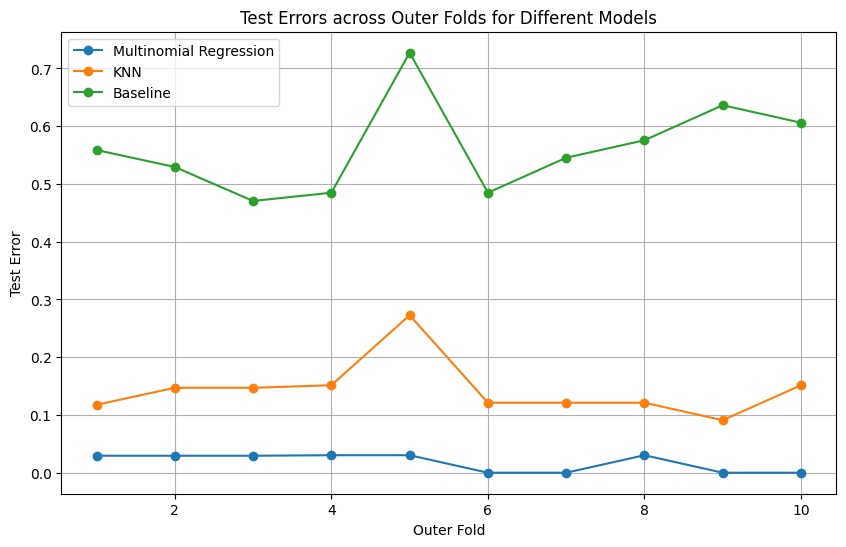

In [17]:
import matplotlib.pyplot as plt

# Plotting test errors for each model across outer folds
plt.figure(figsize=(10, 6))

# Plot test errors for each model
plt.plot(results_df["Outer Fold"], results_df["Multinomial Regression Test Error"], label="Multinomial Regression", marker='o')
plt.plot(results_df["Outer Fold"], results_df["KNN Test Error"], label="KNN", marker='o')
plt.plot(results_df["Outer Fold"], results_df["Baseline Test Error"], label="Baseline", marker='o')

# Add labels and title
plt.xlabel("Outer Fold")
plt.ylabel("Test Error")
plt.title("Test Errors across Outer Folds for Different Models")
plt.legend()
plt.grid()
plt.show()


In [18]:
# Retrieve the best C found in the grid search
best_C = multinomial_search.best_params_['C']
# Convert to lambda
best_lambda = 1 / best_C
print("Best lambda:", best_lambda)

Best lambda: 1.0


In [ ]:
# Get the learned coefficients from the best estimator in the grid search
best_model = multinomial_search.best_estimator_
coefficients = best_model.coef_

feature_coefficients = pd.DataFrame(coefficients, columns=attributeNames)
feature_coefficients.index = best_model.classes_  # Label the rows with class names

print("Learned coefficients for each class:")
print(feature_coefficients)


Learned coefficients for each class:
           culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
Adelie            -0.796702         1.129664           0.072471     0.000771
Chinstrap          1.283329         0.008014          -0.157871    -0.006393
Gentoo            -0.486628        -1.137677           0.085400     0.005622
